# Part 1: Data Ingestion

This demo showcases financial fraud prevention and using the MLRun feature store to define complex features that help identify fraud. Fraud prevention specifically is a challenge as it requires processing raw transaction and events in real-time and being able to quickly respond and block transactions before they occur.

To address this, we create a development pipeline and a production pipeline. Both pipelines share the same feature engineering and model code, but serve data very differently. Furthermore, we automate the data and model monitoring process, identify drift and trigger retraining in a CI/CD pipeline. This process is described in the diagram below:

For any additional information go to this [link](https://docs.mlrun.org/en/latest/feature-store/feature-sets.html)

![Feature store demo diagram - fraud prevention](./images/feature_store_demo_diagram.png)

The raw data is described as follows:

| TRANSACTIONS                                                                     || &#x2551; 
|-----------------|----------------------------------------------------------------|----------|
| **age**         | age group value 0-6. Some values are marked as U for unknown   | &#x2551; |
| **gender**      | A character to define the age                                  | &#x2551; |
| **zipcodeOri**  | ZIP code of the person originating the transaction             | &#x2551; |
| **zipMerchant** | ZIP code of the merchant receiving the transaction             | &#x2551; |  
| **category**    | category of the transaction (e.g., transportation, food, etc.) | &#x2551; | 
| **amount**      | the total amount of the transaction                            | &#x2551; |
| **fraud**       | whether the transaction is fraudulent                          | &#x2551; |
| **timestamp**   | the date and time in which the transaction took place          | &#x2551; | 
| **source**      | the ID of the party/entity performing the transaction          | &#x2551; |  
| **target**      | the ID of the party/entity receiving the transaction           | &#x2551; | 
| **device**      | the device ID used to perform the transaction                  | &#x2551; |
| **event**       | event, such as login or password                               | &#x2551; |

This notebooks introduces how to **Ingest** data to Feature Set with several steps, Train a Model and Create One Feature Set for ingection and prediction - For complete this tutorial you will need to run this 3 notebooks

By the end of this tutorial you’ll learn how to:

- Create an ingestion pipeline for a data source.
- Define preprocessing, aggregation and validation of the pipeline.
- Ingest data to your Feature Set.
- Creating a Feature Vector
- Train a model based your Feature Vector
- Add steps to an excisting Feature Set
- Create One Feature Set for ingection and prediction 

For this demo you need to install ``pip install scikit-learn~=1.0`` 

In [1]:
# pip install scikit-learn~=1.0

install mlrun - if does not install use ``pip install mlrun==<mlrun server version>`` or ``sh align_mlrun.sh`` (our default mlrun installer - automatically install the server version)

In [2]:
#!sh /User/align_mlrun.sh

When you comple

In [3]:
import mlrun

In [4]:
# Import pandas package
import pandas as pd

In [5]:
# Import MLRun's Feature Store
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import OneHotEncoder, MapValues, DateExtractor

For Creating a project you need use the mlrun.[get_or_create_project](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=get_or_create_project#mlrun.projects.get_or_create_project) method.

we defined the project name as 'fraud-demo' and the context (the project local directory path) to be './'

In [6]:
project_name = 'fraud-predict-demo'

In [7]:
project  = mlrun.get_or_create_project(project_name,'./',user_project=True)

> 2022-08-01 07:49:32,986 [info] loaded project fraud-predict-demo from None or context and saved in MLRun DB


In [8]:
# Recive our datafrae from fraud_data.csv file
data_df = pd.read_csv('./fraud_data.csv')

In MLRun we use # mlrun: start-code and # mlrun: end-code to rap you code between those two lines and mlrun know to convert it to a MLRun function.

You can find any additional information [here](https://docs.mlrun.org/en/latest/runtimes/mlrun_code_annotations.html?highlight=start-code#converting-notebook-code-to-a-function)

In [9]:
# mlrun: start-code

In [10]:
# this custom steps create a lable column base on the fraud column 
# when we will train the model, it will not save the label column in the model feature becuase of that wee need to create this copy 
def create_labels(event):
    event['label'] = event["fraud"]
    return event

In [11]:
# mlrun: end-code

Define which categories to map with our built in One Hot Encoder.

MLRun as many built-in steps that you can use when building your graph using storey enging like the OneHotEncoder - You can find any additional information [here](https://docs.mlrun.org/en/latest/serving/available-steps.html) 

In [12]:
main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]

one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(data_df.gender.unique()),'event': list(data_df.event.unique()[:-1]),
                          'event': list(data_df.event.unique()[:-1])}

#### Define your Feature Set
For Define your Feature Set use [FeatureSet](https://docs.mlrun.org/en/latest/api/mlrun.feature_store.html#mlrun.feature_store.FeatureSet) method and provide:
1. Feature Set Name - Your Feature Set Name, for example: transactions
2. entities - Your Primary Key, for example: source
3. timestamp_key - Your Timestamp Key for example: timestamp

In [13]:
# Define the transactions FeatureSet
transaction_set = fstore.FeatureSet("transactions", 
                                 entities=[fstore.Entity("source")], 
                                 timestamp_key='timestamp', 
                                 description="transactions feature set")

After you creating your feature set you need to add your steps to the feature set - for defualt feature set use storey engine to run those steps (this demo uses storey engine).

The **pandas** and **spark** engines are good for simple batch transformations, while the **storey** stream processing engine (the default engine) can handle complex workflows and real-time sources.

In [14]:
transaction_set.graph.to(OneHotEncoder(mapping=one_hot_encoder_mapping))\
    .to(DateExtractor(parts = ['hour', 'day_of_week'], timestamp_col = 'timestamp'))\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(name='create_labels',handler='create_labels')


# Add aggregations for 2, 12, and 24 hour time windows
transaction_set.add_aggregation(before='create_labels',after='MapValues',name='amount',
                                column='amount',
                                operations=['avg','sum', 'count','max'],
                                windows=['2h', '12h', '24h'],
                                period='1h')


# Add the category aggregations over a 14 day window
for category in main_categories:
    transaction_set.add_aggregation(before='create_labels',after='MapValues',name=category,column=f'category_{category}',
                                    operations=['count'], windows=['14d'], period='1d')



By Default Feature Set as two targets.
1. Parquet - For offline target.
2. NoSql - For Online target.

You can modify the targets by flag the value to ``with_default=False`` and define which built in storey targets to use (TSBDTarget, StreamTarget, CSVTarget, ToDataFrame, ParquetTarget, CSVTarget), for example ``targets=[CSVTarget(),ParquetTarget()]``

You can find any additional information about Feature Set targets [here](https://docs.mlrun.org/en/latest/serving/available-steps.html#targets)

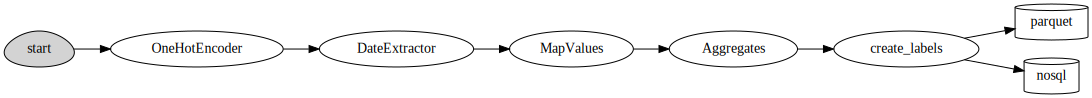

In [15]:
transaction_set.set_targets()

# Plot the pipeline so we can see the different steps
transaction_set.plot(rankdir="LR", with_targets=True)

[fstore.ingest](https://docs.mlrun.org/en/latest/api/mlrun.feature_store.html?highlight=ingest#mlrun.feature_store.ingest) method Read local DataFrame, file, URL, or source into the feature store Ingest reads from the source, run the graph transformations, infers metadata and stats and writes the results to the default of specified targets

when targets are not specified data is stored in the configured default targets (will usually be NoSQL for real-time and Parquet for offline).


In [16]:
ingest_df = fstore.ingest(transaction_set,data_df[0:500],overwrite=True)

In [17]:
#example of the Feature Set
ingest_df

,amount_sum_2h,amount_sum_12h,amount_sum_24h,amount_max_2h,amount_max_12h,amount_max_24h,amount_count_2h,amount_count_12h,amount_count_24h,amount_avg_2h,...,fraud,timestamp,target,device,event_login,event_details_change,event_password_change,timestamp_hour,timestamp_day_of_week,label
source,,,,,,,,,,,,,,,,,,,,,
C792341594,8.62,8.62,8.62,8.62,8.62,8.62,1.0,1.0,1.0,8.62,...,0,2022-07-26 17:09:57.487,M1823072687,20aa62c2244147d1a61f2c1addc7d33e,1,0,0,17,1,0
C792341594,17.24,17.24,17.24,8.62,8.62,8.62,2.0,2.0,2.0,8.62,...,0,2022-07-26 17:09:57.487,M1823072687,20aa62c2244147d1a61f2c1addc7d33e,0,1,0,17,1,0
C792341594,25.86,25.86,25.86,8.62,8.62,8.62,3.0,3.0,3.0,8.62,...,0,2022-07-26 17:09:57.487,M1823072687,20aa62c2244147d1a61f2c1addc7d33e,1,0,0,17,1,0
C792341594,34.48,34.48,34.48,8.62,8.62,8.62,4.0,4.0,4.0,8.62,...,0,2022-07-26 17:09:57.487,M1823072687,20aa62c2244147d1a61f2c1addc7d33e,1,0,0,17,1,0
C792341594,43.10,43.10,43.10,8.62,8.62,8.62,5.0,5.0,5.0,8.62,...,0,2022-07-26 17:09:57.487,M1823072687,20aa62c2244147d1a61f2c1addc7d33e,0,1,0,17,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C841956493,84.80,84.80,84.80,5.30,5.30,5.30,16.0,16.0,16.0,5.30,...,0,2022-07-26 21:16:40.929,M1823072687,c5d5b2df6a9c45938b2142b1890c2697,0,1,0,21,1,0
C841956493,90.10,90.10,90.10,5.30,5.30,5.30,17.0,17.0,17.0,5.30,...,0,2022-07-26 21:16:40.929,M1823072687,c5d5b2df6a9c45938b2142b1890c2697,0,0,1,21,1,0
C841956493,95.40,95.40,95.40,5.30,5.30,5.30,18.0,18.0,18.0,5.30,...,0,2022-07-26 21:16:40.929,M1823072687,c5d5b2df6a9c45938b2142b1890c2697,1,0,0,21,1,0


# 

### Done!
Now you create your transactions Feature Set, and you are ready to train your model